# Bangladeshi naiste tervisenäitajate mõju rasedusaegsele riskihinnangule
#### Projekti tiim:
* Natalja Beljajeva
* Mari Helen Štarkov
* Hannes Aaresild

## Motivatsioon
### Igal aastal on 7660 surma, mis oleks ennetatavad.

### Mis juhul peaks muutuma valvsaks ehk uurimisküsimused?
 1. Kuidas mõjutavad andmestikus olevad tervisetunnused riskihinnangut?
 2. Millised tunnused mõjutavad riskihinnangut olulisemalt?
 3. Milliste tunnuste koosmõju on riskihinnangule olulisim?

### IoT seadmetega on kogutud andmed Kaggle-sse.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


data = pd.read_csv("Maternal_Health_Risk_Dataset.csv")
data.describe().round(1)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0
mean,29.9,113.2,76.5,8.7,98.7,74.3
std,13.5,18.4,13.9,3.3,1.4,8.1
min,10.0,70.0,49.0,6.0,98.0,7.0
25%,19.0,100.0,65.0,6.9,98.0,70.0
50%,26.0,120.0,80.0,7.5,98.0,76.0
75%,39.0,120.0,90.0,8.0,98.0,80.0
max,70.0,160.0,100.0,19.0,103.0,90.0


## Kas ja kui palju on duplikaate?

In [2]:
data.duplicated().sum()

562

In [3]:
# Eemaldame "Sureva inimese"
cleaned_data = data[data['HeartRate'] != 7]

# Duplikaatideta 
cleaned_data = cleaned_data.drop_duplicates()
cleaned_data.describe().round(1)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,451.0,451.0,451.0,451.0,451.0,451.0
mean,29.2,110.5,75.4,8.3,98.7,74.1
std,13.8,17.9,13.8,2.8,1.4,7.5
min,10.0,70.0,49.0,6.0,98.0,60.0
25%,19.0,90.0,65.0,6.9,98.0,70.0
50%,25.0,120.0,80.0,7.5,98.0,76.0
75%,35.0,120.0,87.0,7.9,98.0,80.0
max,70.0,160.0,100.0,19.0,103.0,90.0


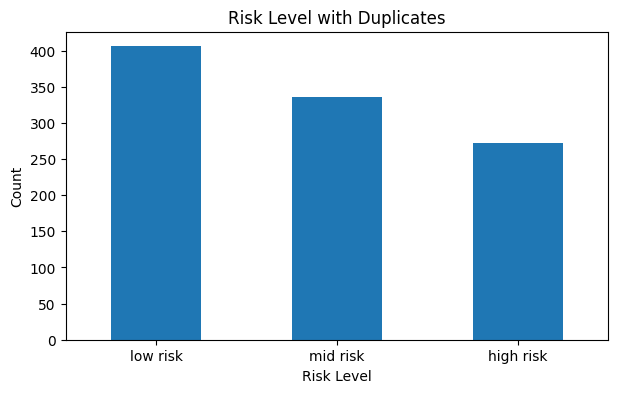

In [4]:
# Loome histogrammi RiskLevel veeru jaoks, et kontrollida klasside jaotust
plt.figure(figsize=(7, 4))
data['RiskLevel'].value_counts().plot(kind='bar')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.title('Risk Level with Duplicates')
plt.xticks(rotation=360)
plt.show()

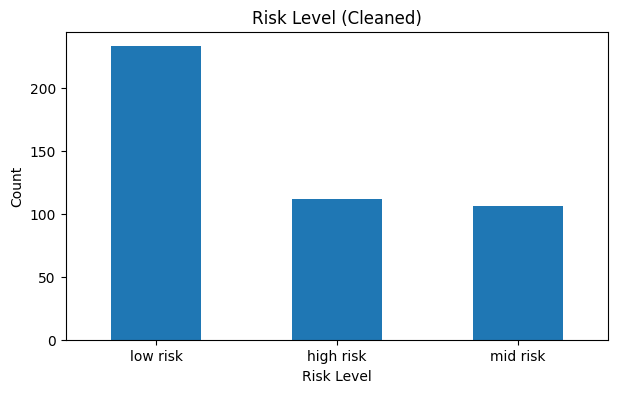

In [5]:
# Loome histogrammi RiskLevel veeru jaoks, et kontrollida klasside jaotust
plt.figure(figsize=(7, 4))
cleaned_data['RiskLevel'].value_counts().plot(kind='bar')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.title('Risk Level (Cleaned)')
plt.xticks(rotation=360)
plt.show()
#cleaned_data.head(50)

## Tihti saab vajaliku teabe juba kätte lihtsal visualiseerimisel

## Vastame uurimisküsimusele nr 1
### Kuidas mõjutavad andmestikus olevad tervisetunnused riskihinnangut?

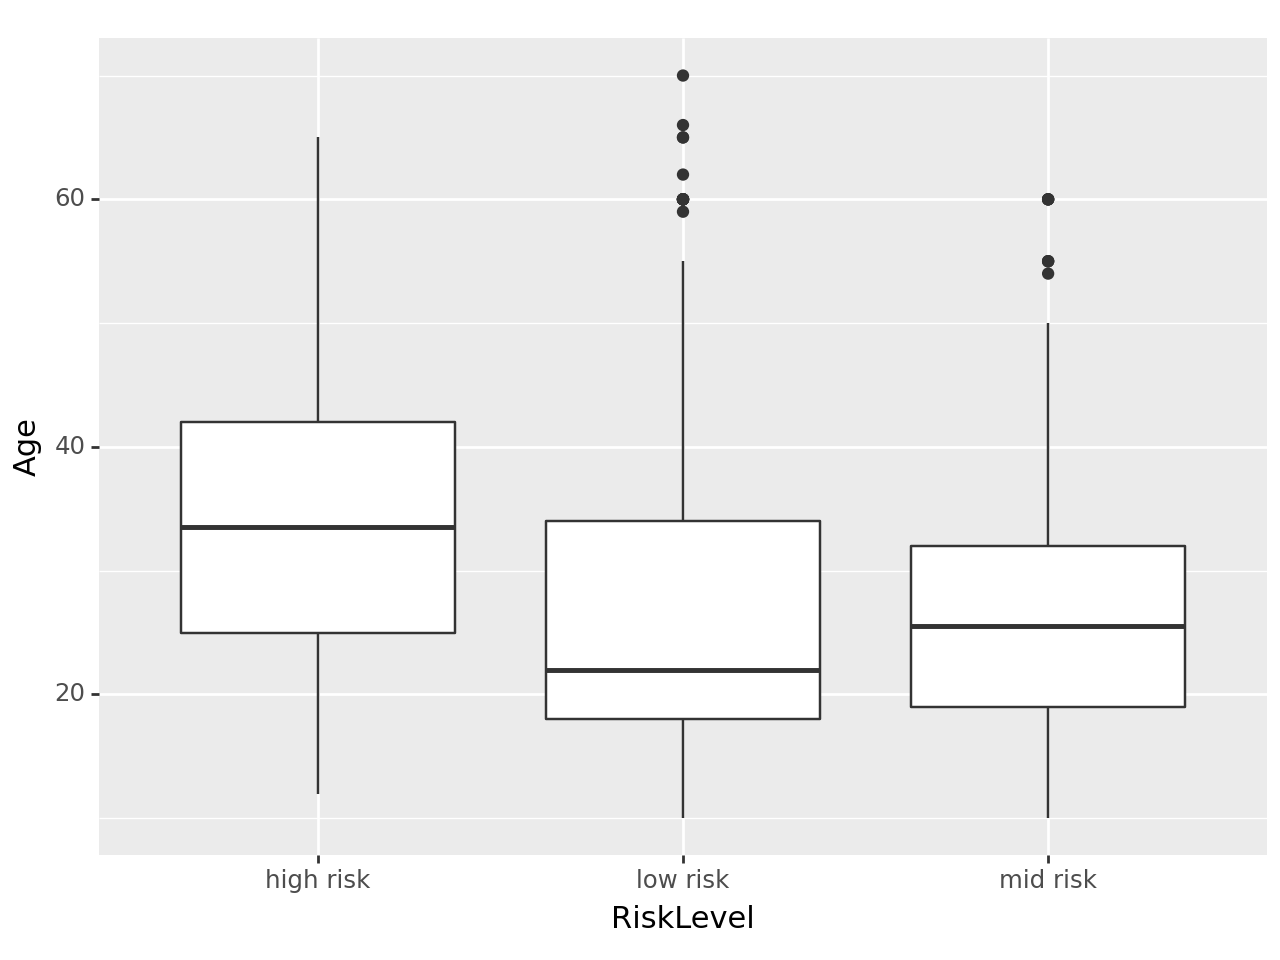

<Figure Size: (640 x 480)>

In [6]:
(p9.ggplot(
    data = cleaned_data, 
    mapping = p9.aes(x = 'RiskLevel', y = 'Age')
 )+ 
    p9.geom_boxplot())

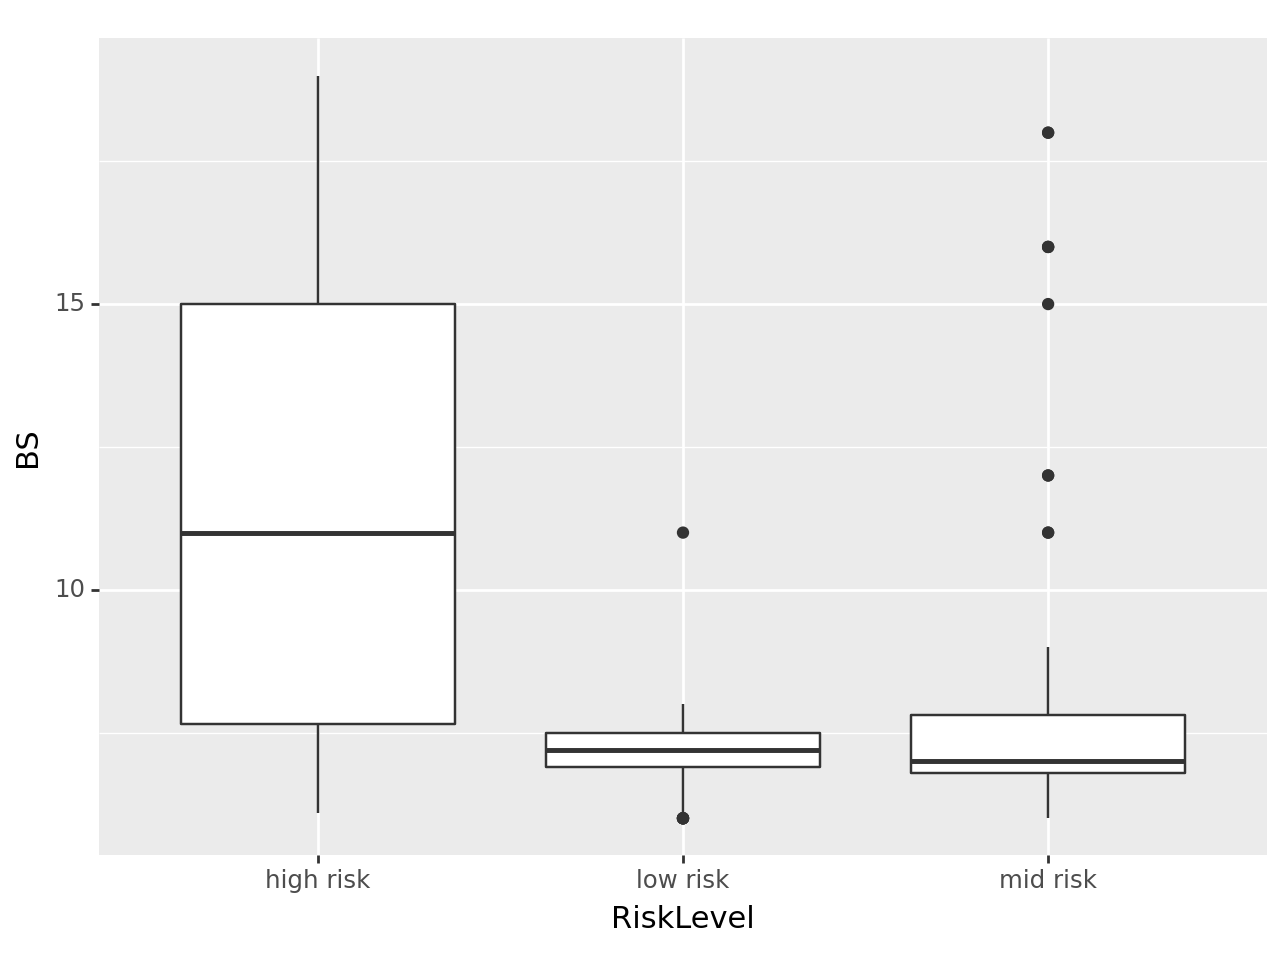

<Figure Size: (640 x 480)>

In [7]:
(p9.ggplot(
    data = cleaned_data, 
    mapping = p9.aes(x = 'RiskLevel', y = 'BS')
 )+ 
    p9.geom_boxplot())

## Otsisime kinnitust Kruskal-Wallise testiga

In [8]:
# Anname riskihinnangule arvulised väärtused
risk_level_mapping = {'low risk': 1, 'mid risk': 2, 'high risk': 3}
cleaned_data['RiskLevel_encoded'] = cleaned_data['RiskLevel'].map(risk_level_mapping)

# Performing Kruskal-Wallis test for each column against 'RiskLevel'
kruskal_test_results = {}

# Splitting the data based on RiskLevel
groups = cleaned_data.groupby('RiskLevel_encoded')

for column in cleaned_data.columns:
    # Extracting the data for each group
    data_groups = [group[column].values for name, group in groups]
    statistic, p_value = kruskal(*data_groups)
    kruskal_test_results[column] = p_value

results_df = pd.DataFrame(list(kruskal_test_results.items()), columns=['Feature', 'P-Value'])
results_df['Significant'] = results_df['P-Value'] <= 0.05

results_df

,Feature,P-Value,Significant
0,Age,9.336876e-06,True
1,SystolicBP,1.885450e-10,True
2,DiastolicBP,2.849203e-06,True
3,BS,6.936817e-24,True
4,BodyTemp,1.183313e-07,True
5,HeartRate,7.322151e-04,True
6,RiskLevel,1.921948e-98,True
7,RiskLevel_encoded,1.921948e-98,True


## Korrelatsioonigraafik

## Vastame uurimisküsimusele nr 2
### Millised tunnused mõjutavad riskihinnangut olulisemalt?

In [9]:
# Random_Forest optimeeritud hüperparameetritega

clean_data = cleaned_data.drop('RiskLevel_encoded', axis=1) 

X = clean_data.drop('RiskLevel', axis=1)
y = clean_data['RiskLevel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

train_indices = X_train.index
test_indices = X_test.index


rf_model = RandomForestClassifier(n_estimators=50, max_features=1,max_depth =5, min_samples_leaf=1, min_samples_split=3 ,random_state=1)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, rf_pred)
accuracy_percentage = round(accuracy * 100, 1)
report = classification_report(y_test, rf_pred, output_dict=True)

print(f"Accuracy of Random Forest: {accuracy_percentage}%")

for label in report:
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {label}:")
        print(f" Precision: {report[label]['precision']:.2f}")
        print(f" Recall: {report[label]['recall']:.2f}")
        print(f" F1-score: {report[label]['f1-score']:.2f}\n")

Accuracy of Random Forest: 73.6%
Class high risk:
 Precision: 0.90
 Recall: 0.73
 F1-score: 0.81

Class low risk:
 Precision: 0.69
 Recall: 1.00
 F1-score: 0.82

Class mid risk:
 Precision: 0.67
 Recall: 0.26
 F1-score: 0.38



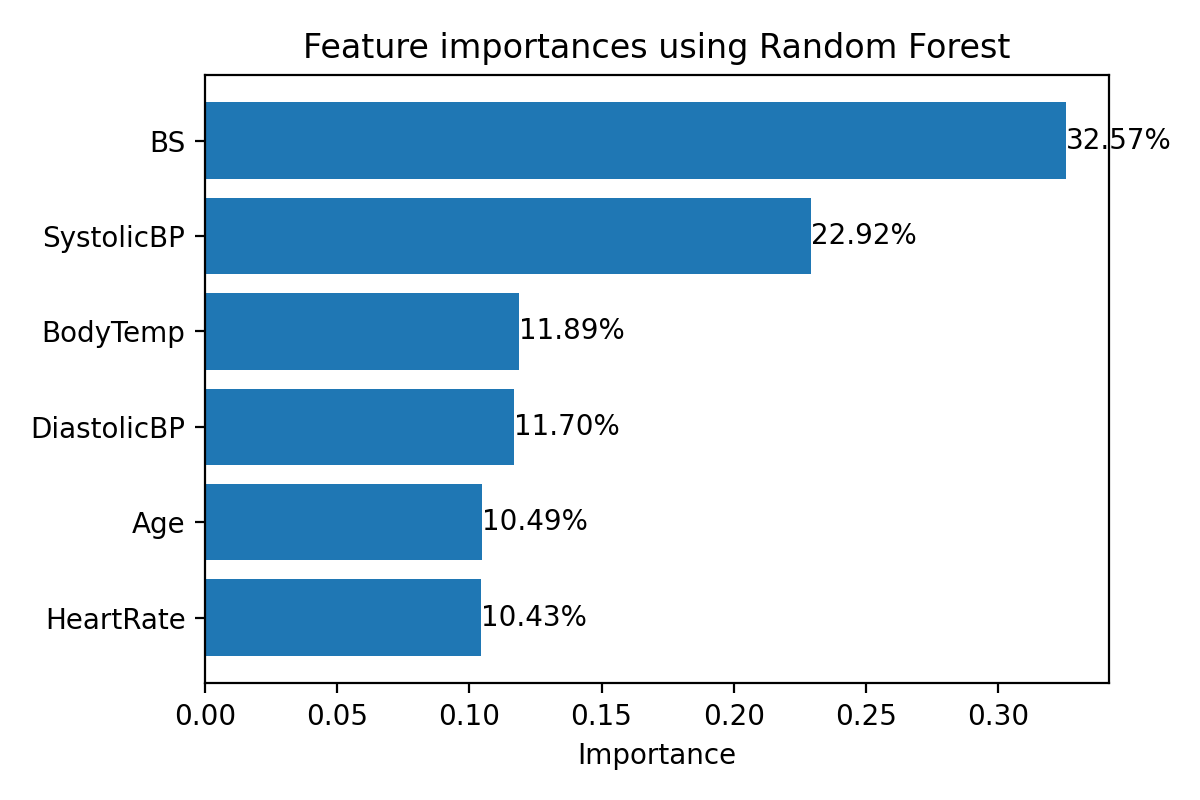

In [10]:
#Feature importances using Random Forest
feature_importances = rf_model.feature_importances_
feature_names = clean_data.columns[:-1] 

sorted_idx = feature_importances.argsort()

plt.figure(figsize=(6,4))
bars = plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2%}', 
             va='center')
plt.yticks(range(X_train.shape[1]), feature_names[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances using Random Forest')
plt.tight_layout()
plt.show()


## Vastame uurimisküsimusele nr 3
### Milliste tunnuste koosmõju on riskihinnangule olulisim?

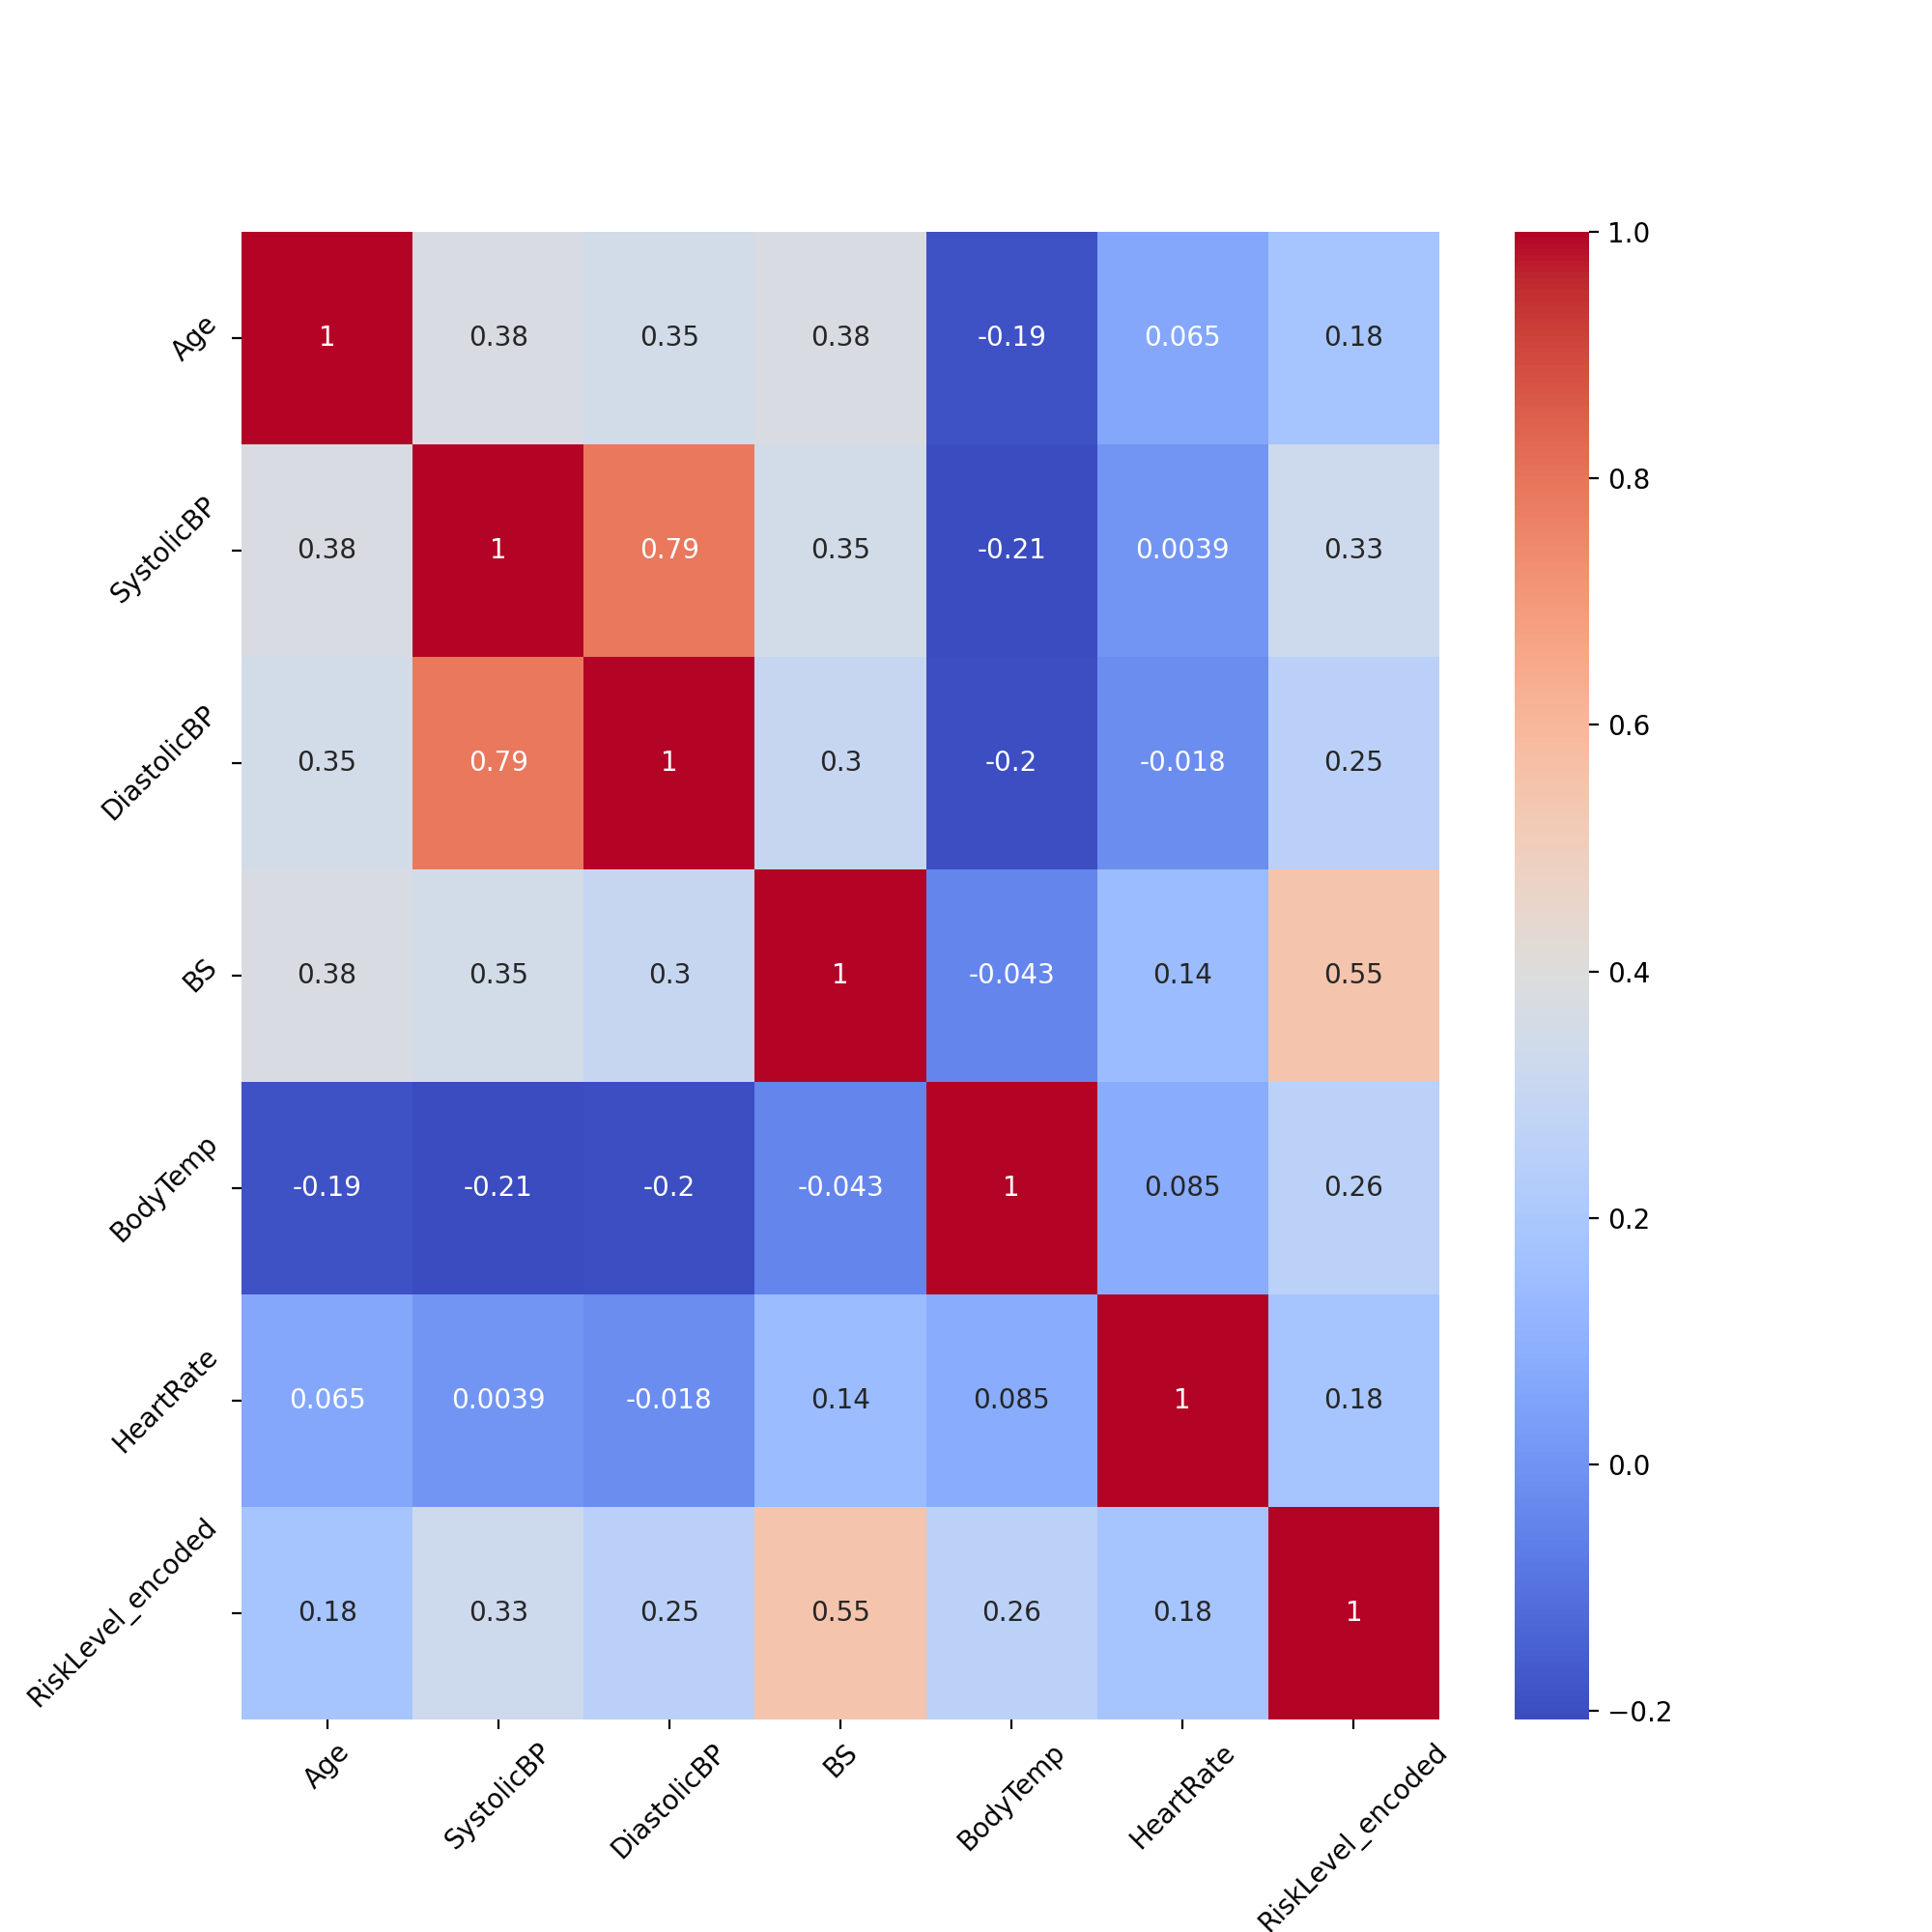

In [11]:
#korrelatsioonianalüüs
corr = cleaned_data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate','RiskLevel_encoded']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
#üldiselt tunnused omavahel tugevalt seotud ei ole, välja arvatud alumine ja ülemine vererõhk, mis on ka loogiline